In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [133]:
pip install pyttsx3

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: comtypes in c:\users\kiit\anaconda3\lib\site-packages (from pyttsx3) (1.1.9)



# Read Captions File

In [2]:
# Reading the Description file

with open("./Flickr_Data/Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()


In [3]:
captions = captions.split("\n")[:-1]

In [4]:
len(captions)

40460

In [5]:
# captions[0]
captions[0].split("\t")

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [6]:
first,second = captions[0].split("\t")
print(first)
print(first.split("."))
print(second)

1000268201_693b08cb0e.jpg#0
['1000268201_693b08cb0e', 'jpg#0']
A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
# Creating a "descriptions" dictionary where key is 'img_name' and value is list of captions corr to that image_file.

descriptions = {}

for x in captions:
    first,second = x.split("\t")                       #as every caption is separated by \t
    img_name = first.split(".")[0]                  #split first part around the dot
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(second)

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [9]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ",sample)
    sample = sample.split()
    sample = [s for s in sample if len(s)>1]
    sample = " ".join(sample)
    return sample

In [10]:
clean_text("A cat is sitting under the house # 64")

'cat is sitting under the house'

In [11]:
#  modify all the captions i.e - cleaned captions

for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [12]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# Writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

# Vocabulary

In [14]:
# Reading description file

descriptions=None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [15]:
# Finding the vocabulary(set of all unique words the model can predict)

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [16]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))

Vocabulary Size: 373837


In [17]:
# Count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections
counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [18]:
len(all_vocab)

1845

# Loading Training Testing Data

In [19]:
# TrainImagesFile
with open("./Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt") as filepath:
    train_data = filepath.read()
    filepath.close()

In [20]:
print(train_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [21]:
train  = [e.split(".")[0] for e in train_data.split("\n")[:-1]]

In [22]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [23]:
# TestImagesFile
with open("./Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt") as f:
    test_data = f.read()
    f.close()

In [24]:
test  = [e.split(".")[0] for e in test_data.split("\n")[:-1]]

In [25]:
len(test)

1000

In [26]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for capt in descriptions[img_id]:
        cap_to_append = "startseq " + capt + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [27]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [85]:
train_descriptions

{'2513260012_03d33305cf': ['startseq black dog is running after white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through low lying body of water endseq'],
 '2903617548_d3e38d7f88': ['startseq little baby plays croquet endseq',
  'startseq little girl plays croquet next to truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of car with put and ball endseq',
  'startseq the little boy is playing with croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8': ['startseq brown dog in the snow has something hot pink in its mouth endseq',
  'startseq brown dog in the snow holding pink hat endseq',
  'startseq brown dog is holding pink shirt in the snow endseq',
  'startseq dog is carrying something pink in its mouth whil

# Data Preprocessing - Images

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
#This cell must be executed before  all below cells else output will come.

In [29]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [30]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [32]:
IMG_PATH = "./Flickr_Data/Images/"

In [33]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


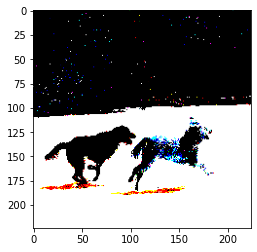

In [34]:
img = preprocess_image(IMG_PATH+"2513260012_03d33305cf.jpg")
plt.imshow(img[0])
plt.show()

In [35]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [36]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535922, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [36]:
start = time()

encoding_train = {}

for ix, img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [40]:
encoding_train['2513260012_03d33305cf']

array([0.34707946, 0.5115909 , 0.08728854, ..., 1.1897293 , 0.04043847,
       0.15271065], dtype=float32)

In [158]:
encoding_test={}
start_time=time()
for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    if ix%100==0:
        print("Encoding in Progress Time Step %d"%ix)
end_time=time()
print("Total Time taken :",(end_time-start_time))

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Total Time taken : 192.7619490623474


In [159]:
print(len(encoding_test))

1000


In [160]:
# Save the bottleneck train features to disk

with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train,f)
print(len(encoding_train))

6000


In [161]:
# Save the bottleneck test features to disk

with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)
print(len(encoding_test))

1000


In [37]:
# Load the train images features from disk

with open("./encoded_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [38]:
# Load the test images features from disk

with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

# Data Preprocessing - Captions

In [39]:
len(all_vocab)

1845

In [40]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(all_vocab):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word


In [41]:
word_to_idx["dog"]

6

In [42]:
idx_to_word[6]

'dog'

In [43]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [44]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [45]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


# Data Preparation using Generator Function

In [101]:
from numpy import array

In [102]:
def data_generator(train_descriptions,encoding_train,word_to_ind,max_len,num_photos_per_batch):
    #batch_size is how many training examples we should have in 1 batch.
    #Our data has 2 parts-:1)Image 2)Partial Captions.
    #We are going to build partial captions
    X1,X2,y=list(),list(),list()
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for desc in desc_list:
                sequence=[word_to_idx[word] for word in desc.split(' ') if word in word_to_idx]
                #for all unknown words(not present in word_to_index) ,we are going to ignore it 
                for i in range(1,len(sequence)):
                    xi=sequence[:i]
                    yi=sequence[i]
                    #Later ,we will do padding which will ensure every xi is of same length
                    #using pad_sequences function available in keras,It accepts a 2D list and returns a 2D Matrix.
                    #[[xi]]--->Here xi is a 2D matrix.
                    #0 denote padding word
                    #padding='post' means we are adding zeros after Sequence of words.
                    xi=pad_sequences([xi],maxlen=max_len)[0]#Since we have only one example,so we are extracting only first one..
                    yi=to_categorical([yi],num_classes=vocab_size)[0]#yi should be one hot vector.
                    #xi and yi --->one training point
                    #In our mini batch,we are going to append these values.
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    if n==num_photos_per_batch:
                        yield ([array(X1), array(X2)], array(y))
#                         yield [np.array(X1), np.array(X2)], np.array(y)
                        #We are not using return function as it is a Generator 
                        #and Generator remembers the state where the function was in the previous call 
                        #For next batch When control comes back again to this Generator Function:-
                        X1,X2,y=list(),list(),list()
                        n=0

# Word Embedding

In [47]:
f = open("./glove.6B.50d.txt", encoding='utf8')
for line in f:
    values=line.split()
    print(values)
    break
import numpy as np

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581']


In [48]:
embedding_index = {}

for line in f:
    values = line.split()
#     print(values)
#     break
    word = values[0]
    embedding_word = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = embedding_word
    
f.close()

In [49]:
embedding_index['dog']

array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ])

# Converting words into vectors Directly

In [50]:
#Get the glove embedding of the word and then push that vector into the output matrix of corresponding index
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [51]:
embedding_output.shape

(1848, 50)

In [52]:
print(type(embedding_output))

<class 'numpy.ndarray'>


# Model Architecture

In [53]:
#Partial caption(embedding) passed to RNN Layer.It produces some hidden vector
#We combine that hidden vector with image vector and pass it to feed forward network ending with a softmax. Predicts a word
# and then starts predicting next word

In [104]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)
# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
# model.layers[2].set_weights([embedding_output])
# model.layers[2].trainable = False
model.compile(loss="categorical_crossentropy", optimizer="adam")
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       92400       input_11[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_10[0][0]                   
____________________________________________________________________________________________

# Training Our Model

In [105]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)

In [106]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

6000/6000 [==============================] - 1051s 175ms/step - loss: 3.7258


C:\Users\KIIT\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


6000/6000 [==============================] - 1213s 202ms/step - loss: 2.3133


In [112]:
model = load_model("./model_weights/model_9.h5")

In [113]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

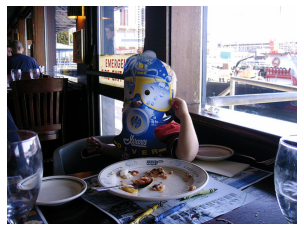

man is sitting in high seat with many people in the background


In [160]:
for i in range(1):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)

In [161]:
import pyttsx3
engine = pyttsx3.init()
""" RATE"""
rate = engine.getProperty('rate')   # getting details of current speaking rate
engine.setProperty('rate', 125)     # setting up new voice rate


"""VOLUME"""
volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
voices = engine.getProperty('voices')       #getting details of current voice
engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
# engine.setProperty('voice', voices[1].id)   #changing index, changes voices. 1 for female

engine.say(caption)
engine.runAndWait()
engine.stop()